# Optimal Convolution Procedure

## The Problem
The current bottleneck in the [sstcam-simulation](https://github.com/sstcam/sstcam-simulation) package is the convolution with the pulse shape. The current approach uses `scipy.ndimage.convolve1d`, which applies the covolution across the waveforms of multiple pixels simulataneously. Can we find a better convolution procedure for our use case to remove this bottleneck?

## Step 1: Prepare data

In [1]:
import numpy as np
from scipy.ndimage import convolve1d
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
sample_width = 0.1

ref_time = np.arange(0, 30, sample_width)
reference_pulse = norm.pdf(ref_time, loc=15, scale=2)
reference_pulse /= reference_pulse.sum() * sample_width
origin = reference_pulse.argmax() - reference_pulse.size // 2


def get_photoelectron_array(n_pixels, duration):
    n_samples = int(duration / sample_width)
    array = np.zeros((n_pixels, n_samples))
    middle = n_samples // 2
    array[:, middle] = 1
    t = np.linspace(0, duration, n_samples)
    return t, array

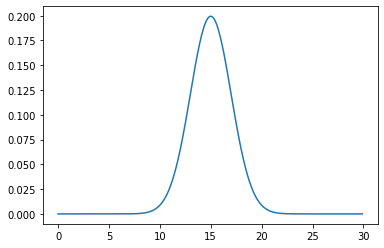

In [3]:
# Reference pulse
_ = plt.plot(ref_time, reference_pulse)

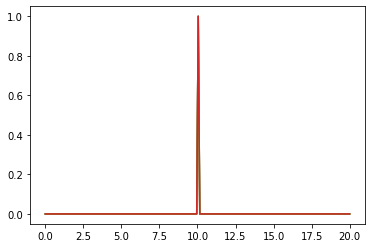

In [4]:
# Example photoelectron array
t, photoelectrons = get_photoelectron_array(4, 20)
_ = plt.plot(t, photoelectrons.T)

## Step 2: Exploring current method

Lets see the current performance, and determine some unit tests to ensure other methods produce the same result.

In [5]:
def convolve_convolve1d(pe, ref):
    return convolve1d(pe, ref, mode="constant", origin=origin)

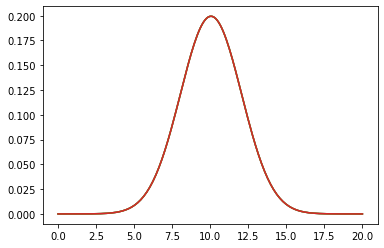

In [39]:
# Example convolution result
t, photoelectrons = get_photoelectron_array(4, 20)
_ = plt.plot(t, convolve_convolve1d(photoelectrons, reference_pulse).T)

In [40]:
def test_method(method, ref):
    t, pe = get_photoelectron_array(4, 20)
    np.testing.assert_almost_equal(convolve_convolve1d(pe, ref), method(pe, ref))

In [41]:
def get_performance_versus_waveform_duration(method, ref):
    duration_array = np.logspace(1, 3, 50)
    time_array = np.zeros(duration_array.size)
    for i, duration in enumerate(duration_array):
        t, pe = get_photoelectron_array(4, duration)
        time = %timeit -q -o -r 1 -n 10 method(pe, ref)
        time_array[i] = time.average
    return duration_array, time_array

In [42]:
def get_performance_versus_n_pixels(method, ref):
    n_pixel_array = np.logspace(1, 3, 50, dtype=np.int)
    time_array = np.zeros(n_pixel_array.size)
    for i, n_pixels in enumerate(n_pixel_array):
        t, pe = get_photoelectron_array(n_pixels, 20)
        time = %timeit -q -o -r 1 -n 10 method(pe, ref)
        time_array[i] = time.average
    return n_pixel_array, time_array

In [43]:
test_method(convolve_convolve1d, reference_pulse)

Text(0, 0.5, 'Execution time (seconds)')

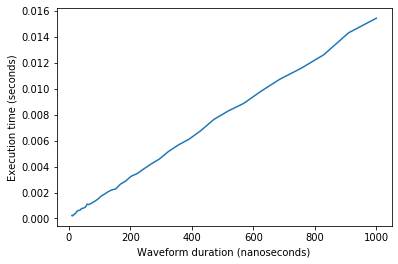

In [44]:
duration, time = get_performance_versus_waveform_duration(convolve_convolve1d, reference_pulse)
plt.plot(duration, time)
plt.xlabel("Waveform duration (nanoseconds)")
plt.ylabel("Execution time (seconds)")

Text(0, 0.5, 'Execution time (seconds)')

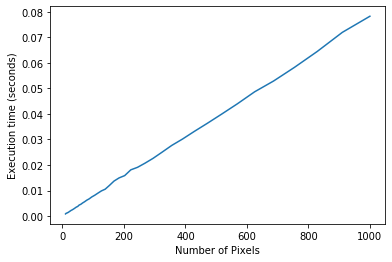

In [45]:
n_pixels, time = get_performance_versus_n_pixels(convolve_convolve1d, reference_pulse)
plt.plot(duration, time)
plt.xlabel("Number of Pixels")
plt.ylabel("Execution time (seconds)")

It does appear that `scipy.ndimage.convolve1d` has linear time complexity (O(n)). So it could be concluded its already very efficient. There are two options apparent to me that could improve the performance of the convolution:
1. Using a Fast Fourier Transform method for convolution. Multiplication in the fourier domain is equivalent to convolution in the time domain. However, this carries the penalty of converting the inputs into the fourier domain and the output back to the time domain. Unfortunately, scipy does not provide a FFT convolution that can be applied along an axis (equivalent to `scipy.ndimage.convolve1d`. This may be an area to revisit in the future.
2. Reduce the amount of the data volume in the convolution by removing insignificant parts.

## Step 3: Reducing the amount of data

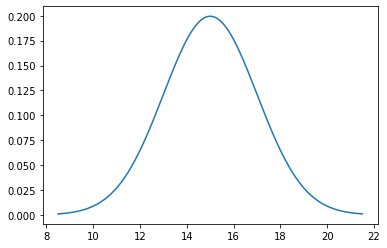

In [87]:
tolerance = 1e-3
ref_start = np.argmax(np.abs(reference_pulse) > tolerance)
ref_end = reference_pulse.size - np.argmax(np.abs(reference_pulse[::-1]) > tolerance)
reference_pulse_clipped = reference_pulse[ref_start:ref_end]

plt.plot(ref_time[ref_start:ref_end], reference_pulse_clipped)

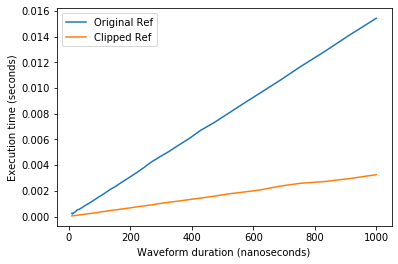

In [88]:
duration, time = get_performance_versus_waveform_duration(convolve_convolve1d, reference_pulse)
plt.plot(duration, time, label="Original Ref")
duration, time = get_performance_versus_waveform_duration(convolve_convolve1d, reference_pulse_clipped)
plt.plot(duration, time, label="Clipped Ref")
plt.xlabel("Waveform duration (nanoseconds)")
plt.ylabel("Execution time (seconds)")
plt.legend()

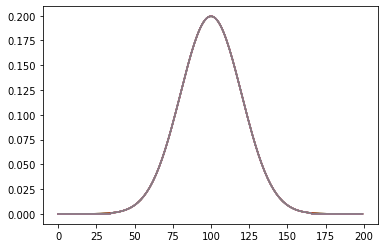

In [91]:
original = convolve_convolve1d(photoelectrons, reference_pulse)
clipped = convolve_convolve1d(photoelectrons, reference_pulse_clipped)
plt.plot(original.T)
_ = plt.plot(clipped.T)